# One more data analysis about the COVID-19, but normalized...

## Table of contents

[Introduction](#Introduction)

[Confirmed cases](#Confirmed-cases)

[Death cases](#Death-cases)

[Mortality rate](#Mortality-rate)

[Recovered cases](#Recovered-cases)

## Introduction

I coded this in order to follow figures about the COVID-19, for curiosity, without any goal else.

It would be very useful and interesting to know :
* the number of tests in each country (maybe the confirmed rate is underestimated) ;
* the fiability of figures of death (countries may hide some death).

I am not a data scientist, thanks for any tip you can give me to improve this code.

Take care,

Yann Marsaud

### What is COVID-19 ?

From the **World Health Organization** : https://www.who.int/news-room/q-a-detail/q-a-coronaviruses

From the **Institut Pasteur** : https://www.pasteur.fr/en/medical-center/disease-sheets/covid-19-disease-novel-coronavirus

### Sources

Data of cases provided by https://github.com/CSSEGISandData/COVID-19

Global data (data/population.csv) from https://data.worldbank.org/indicator/SP.POP.TOTL

In [58]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import psutil
from IPython.core.display import display, HTML
%matplotlib inline

In [101]:
## Functions to clean and prepare data
######################################
## returns a dataframe with the sum of cases for the country_str from the data source src_data
## Country/Region is the new index of this dataframe (=country_str)
def sum_cases(src_data,country_str):
    multi = src_data[src_data["Country/Region"] == country_str]
    multi = multi.groupby(multi["Country/Region"]).sum()
    return multi

## Returns a dataframe with the selected 'countries' and the 'countries_group' 
 # (countries with more than one province) 
 # Extra : prepares timeseries
 # Index of the returned dataframe : 'Country/Region'
def prepare_data(data,countries,countries_group):
    # Loads data from countries ignoring provinces
    data_selected = data[data["Country/Region"].isin(countries) & data["Province/State"].isnull() ]
    data_selected = data_selected.set_index('Country/Region')
    # Agregates country with provinces in the final result
    for c in countries_group:
        data_selected = pd.concat([sum_cases(data,c),data_selected])
    # deleting useless fields
    data_selected = data_selected.drop(["Province/State","Lat","Long"],axis=1) 
    data_selected = data_selected.transpose()
    data_selected.index = pd.to_datetime(data_selected.index)
    data_selected = data_selected.transpose()
    return data_selected

## Returns data normalized to convert data for 10^n inhabitants and transposes it
# data_selected's index is 'Country/Region'
def normalize(data_selected,n):
    data_norm = data_selected.copy()
    # merge data with country names
    data_norm = data_norm.join(population.set_index('Country/Region'))
    data_norm["Population"] = data_norm["Population"] / 10**n
    data_norm = data_norm.div(data_norm["Population"],axis=0)
    data_norm = data_norm.drop(["Population"],axis=1)
    data_norm = data_norm.transpose()
    #data_norm.index = pd.to_datetime(data_norm.index)
    return data_norm

## Prepares and plots with plotly a dataframe with timeseries for index
# df : a dataframe
# meta : contains 'title' and 'filename'
def plot_with_plotly(df,meta):
    df = df.reset_index()
    value_libel = 'Cases'
    df = df.rename(columns={"index":"Date"})
    df = df.melt(id_vars='Date',value_name=value_libel)
    title = meta['title'] + "<br>"+meta['updated']
    fig = px.line(df, x='Date',y=value_libel, 
                  title=title,
                  color='Country/Region',
                 width=800)
                 #width=100%)
    #fig.update_layout(annotations=[
     #   dict(
      #      x=0,
       #     y=1,
        #    showarrow=False,
         #   xref="paper",
          #  yref="paper",
           # text=subtitle,)])
    fig.update_layout(autosize=True,)
    fig.write_image("report/"+meta['filename']+".png")
    fig.show()
    
## returns an array with automatic title and automatic file name
# title_type : one value amongst 'confirmed', 'recovered', 'death', 'mortality'
# time : timestamp
# Returns : an array with 'title', 'filename'
def prepare_metadata(title_type,time):
    titles = {'confirmed':'Confirmed cases for '+'{:,}'.format(10**n),
             'recovered':'Recovered cases for '+'{:,}'.format(10**n),
             'death':'Death cases for '+'{:,}'.format(10**n),
             'mortality' : 'Mortality rate (for 100 confirmed)'}
    updated = "Last updated : " + time.strftime("%Y/%m/%d") 
    filename = "covid19_"+title_type+"_"+time.strftime("%Y_%m_%d")
    return {'title':titles[title_type],'filename':filename,'updated':updated}

def meta_to_html(meta):
    display(HTML("<h4>"+meta['title']+"</h4><h5>"+meta['updated']+"</h5>"))
    
# Basis of normalization : for 10**n inhabitants
n = 6
# Path of imported data
# path = '../data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/'
path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

In [96]:
## Geography
############
# importing data from population, updates data structure
population = pd.read_csv("data/population.csv",header=2)
population = population[["Country Name","2018"]]
population = population.rename(columns={"2018":"Population","Country Name":"Country/Region"}) 
# compatibility of names of country
population.at[249,'Country/Region']  = 'US' 
# selecting countries ignoring provinces
pays = ['France','Argentina','Chile','Italy','US','Spain','United Kingdom','Germany','Brazil']
# selecting countries with provinces
to_agregate = ['Canada','China'] 
# filtering selected countries
population = population[population["Country/Region"].isin(pays) | population["Country/Region"].isin(to_agregate)] 
#population.head()

## Confirmed cases

In [61]:
data_confirmed = pd.read_csv(path+"time_series_covid19_confirmed_global.csv")
confirmed = prepare_data(data_confirmed,pays,to_agregate)
#confirmed

### Raw number of cases

In [88]:
confirmed.transpose().tail(2)

Country/Region,China,Canada,Argentina,Brazil,Chile,France,Germany,Italy,Spain,United Kingdom,US
2020-04-16,83403,30808,2571,30425,8807,145960,137698,168941,184948,103093,667801
2020-04-17,83760,32813,2669,33682,9252,147969,141397,172434,190839,108692,699706


### Normalization of cases for comparison

In [80]:
time = confirmed.transpose().index[-1]
meta = prepare_metadata('confirmed',time)
#meta_to_html(meta)

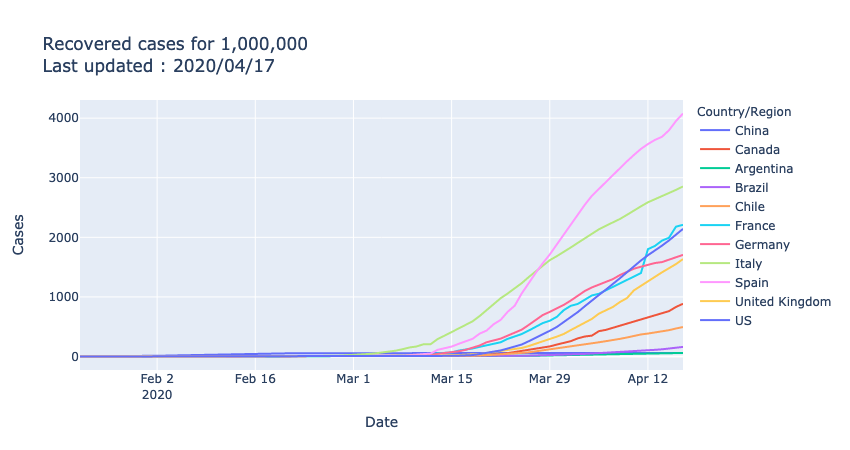

In [102]:
confirmed_norm = normalize(confirmed,n)
#confirmed_norm.plot(title=title)
plot_with_plotly(confirmed_norm,meta)

## Death cases

In [65]:
data = pd.read_csv(path+"time_series_covid19_deaths_global.csv")
death = prepare_data(data,pays,to_agregate)

### Raw number of cases

In [87]:
death.transpose().tail(2)

Country/Region,China,Canada,Argentina,Brazil,Chile,France,Germany,Italy,Spain,United Kingdom,US
2020-04-16,3346,1257,115,1924,105,17920,4052,22170,19315,13729,32916
2020-04-17,4636,1354,123,2141,116,18681,4352,22745,20002,14576,36773


### Normalization of cases for comparison

In [82]:
time = death.transpose().index[-1]
meta = prepare_metadata('death',time)
#meta_to_html(meta)

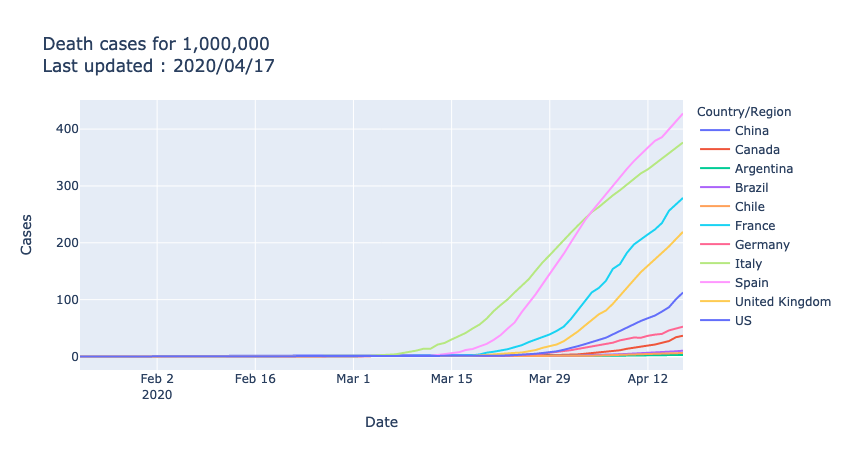

In [83]:
death_norm = normalize(death,n) 
#death_norm.plot(title=title) 
plot_with_plotly(death_norm,meta)

## Mortality rate
This rate is death/confirmed, for 100 confirmed.

In [69]:
death_rate =  death_norm / confirmed_norm * 100

In [84]:
time = death_rate.index[-1]
meta = prepare_metadata('mortality',time)
#meta_to_html(meta)

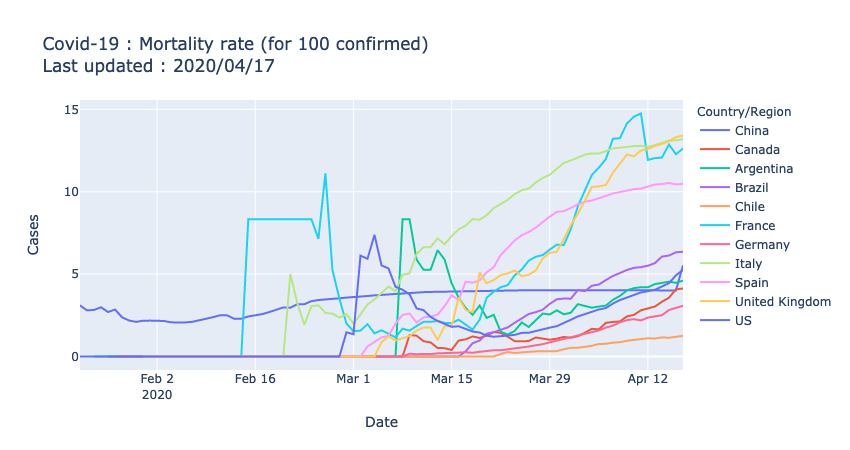

In [71]:
#death_rate.plot(title = title)
plot_with_plotly(death_rate,meta)

### Last mortality rates

In [89]:
death_rate.tail(2)

Country/Region,China,Canada,Argentina,Brazil,Chile,France,Germany,Italy,Spain,United Kingdom,US
2020-04-16 00:00:00,4.011846,4.080109,4.472968,6.323747,1.192233,12.277336,2.942672,13.122925,10.443476,13.317102,4.929013
2020-04-17 00:00:00,5.534862,4.126413,4.608468,6.356511,1.253783,12.624942,3.077859,13.190554,10.481086,13.410371,5.255493


## Recovered cases

In [73]:
data_recovered = pd.read_csv(path+"time_series_covid19_recovered_global.csv")
recovered = prepare_data(data_recovered,pays,to_agregate)

### Raw number of cases

In [90]:
recovered.transpose().tail(2)

Country/Region,China,Canada,Argentina,Brazil,Chile,France,Germany,Italy,Spain,United Kingdom,US
2020-04-16,78401,9698,631,14026,3299,32812,77000,40164,74797,0,54703
2020-04-17,77552,10545,666,14026,3621,34420,83114,42727,74797,0,58545


### Normalization of cases for comparison

In [91]:
time = recovered.transpose().index[-1]
meta = prepare_metadata('recovered',time)
#meta_to_html(meta)

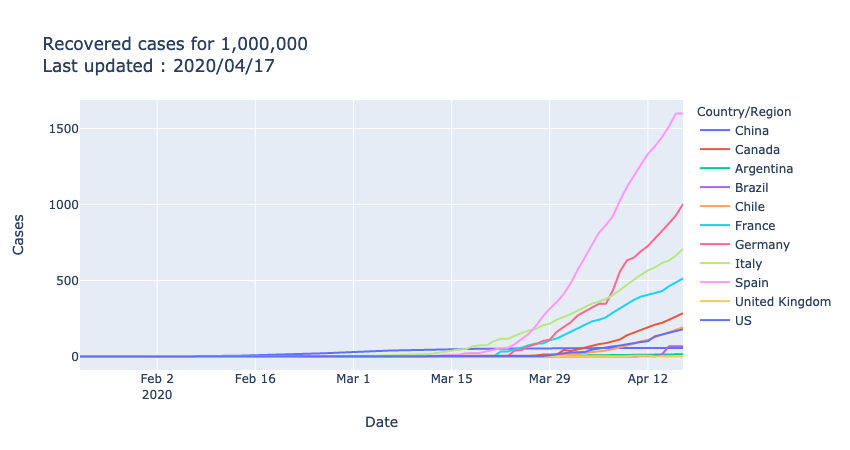

In [92]:
recovered_norm = normalize(recovered,n) 
#recovered_norm.plot(title=title) 
plot_with_plotly(recovered_norm,meta)